# Dogs vs. Cats Redux: Kernels Edition

## Introduction

In this notebook, you will learn how generate and submit predictions to the Kaggle competiton:
[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
    
    

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
``` 
dogs-vs-cats-redux/
    utils.py
    vgg16.py
    vgg16bn.py
    notebook.ipynb
    data/
        train/
            cat.437.jpg
            dog.9924.jpg
            cat.1029.jpg
            dog.4374.jpg
        test/
            231.jpg
            325.jpg
            1235.jpg
            9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside this tutorial directory
```
cd dogs-vs-cats-redux
jupyter notebook
```

In [1]:
# Verify we are in our root directory
%pwd

u'/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux'

In [2]:
# Create references to important directories we will use over and over
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data'

In [3]:
# Import utils modules
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [15]:
# Clean data
%cd $LESSON_HOME_DIR
%rm -rf $LESSON_HOME_DIR/data

## Action plan

1. Create validation set and sample
2. Rearrange image files into their respective directories
3. Finetune and train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## 1. Create validation set and sample

In [4]:
# Create directories
%cd $DATA_HOME_DIR
%mkdir test/unknown
%mkdir results
%mkdir valid
%mkdir -p sample/train
%mkdir sample/test
%mkdir sample/test/unknown
%mkdir sample/results
%mkdir sample/valid

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data


Move subset of data to valid folder:

In [5]:
%cd $DATA_HOME_DIR/train
g = glob('cat.*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): os.rename(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])
    
g = glob('dog.*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): os.rename(shuf[i], DATA_HOME_DIR + '/valid/' + shuf[i])

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/train


Copy subset of train data to train and valid sample folder:

In [6]:
from shutil import copyfile

In [7]:
g = glob('cat.*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], DATA_HOME_DIR + '/sample/train/' + shuf[i])

g = glob('dog.*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], DATA_HOME_DIR + '/sample/train/' + shuf[i])

g = glob('cat.*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR + '/sample/valid/' + shuf[i])

g = glob('dog.*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR + '/sample/valid/' + shuf[i])

Copy subset of test data to test sample folder:

In [8]:
%cd $DATA_HOME_DIR/test
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], DATA_HOME_DIR + '/sample/test/' + shuf[i])

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/test


## 2. Rearrange image files into their respective directories

In [9]:
# Divide cat/dog images into separate directories
%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/train
/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/valid
/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/sample/train
/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/sample/valid


In [10]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

%cd $DATA_HOME_DIR/sample/test
%mv *.jpg unknown/

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/test
/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/sample/test


Validate directories creation:

In [11]:
%cd $DATA_HOME_DIR

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data


In [12]:
%ls test/unknown | wc -l
%ls train/cats | wc -l
%ls train/dogs | wc -l
%ls valid/cats | wc -l
%ls valid/dogs | wc -l

12500
11500
11500
1000
1000


In [13]:
%ls sample/test/unknown | wc -l
%ls sample/train/cats | wc -l
%ls sample/train/dogs | wc -l
%ls sample/valid/cats | wc -l
%ls sample/valid/dogs | wc -l

100
100
100
50
50


## 3. Finetune and train model

Show plots in the web page itself:

In [17]:
%cd $DATA_HOME_DIR

# Instantiate plotting tool
%matplotlib inline

# Import pretrained VGG model
from vgg16 import Vgg16

batch_size = 64

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/' #'/sample/'

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data


In [18]:
vgg = Vgg16()

In [19]:
batches = vgg.get_batches(path + 'train', batch_size = batch_size)
valid_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [20]:
vgg.fit(batches, valid_batches, nb_epoch = 1)

Epoch 1/1
23000/23000 [==============================] - 595s - loss: 0.1180 - acc: 0.9696 - val_loss: 0.0710 - val_acc: 0.9815


In [21]:
vgg.model.save_weights(path + 'results/ft1.h5')

### Run a few more epochs...

In [7]:
vgg.fit(batches, valid_batches, nb_epoch = 1)

Epoch 1/1
23000/23000 [==============================] - 644s - loss: 0.0999 - acc: 0.9759 - val_loss: 0.0546 - val_acc: 0.9865


In [8]:
vgg.model.save_weights(path + 'results/ft2.h5')

In [ ]:
vgg.model.optimizer.lr = 0.01

In [9]:
vgg.fit(batches, valid_batches, nb_epoch = 1)

Epoch 1/1
23000/23000 [==============================] - 645s - loss: 0.0965 - acc: 0.9790 - val_loss: 0.0927 - val_acc: 0.9820


In [10]:
vgg.model.save_weights(path + 'results/ft3.h5')

## 4. Generate predictions

Let's use our new model to make predictions on the test dataset

In [22]:
test_batch_size = 4
test_batches = vgg.get_batches(path + 'test', batch_size = test_batch_size)

Found 12500 images belonging to 1 classes.


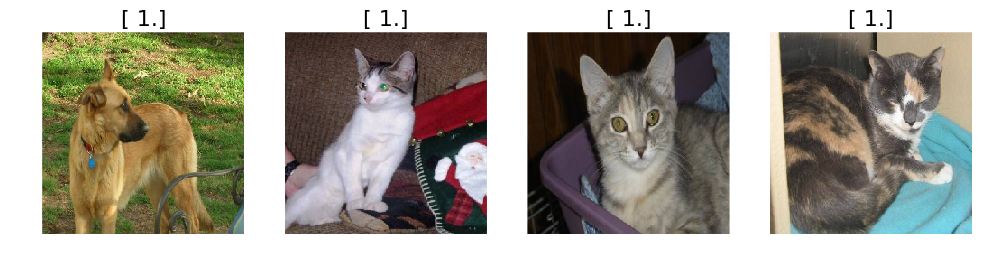

In [23]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)

In [24]:
vgg.predict(test_imgs, True)

(array([ 1.,  1.,  1.,  1.], dtype=float32),
 array([1, 0, 0, 0]),
 ['dogs', 'cats', 'cats', 'cats'])

## 5. Validate predicions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In general, this is a particularly useful technique for debugging problems in the model. 

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [25]:
vgg.model.load_weights(path + 'results/ft1.h5')

In [26]:
val_batches, probs = vgg.test(path + 'valid', batch_size = batch_size)

Found 2000 images belonging to 2 classes.


In [89]:
filenames = val_batches.filenames
expected_labels = val_batches.classes # 0 = cat or 1 = dog

# Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0] # Column 0 = cats probs and column 1 = dogs probs
our_labels = np.round(1-our_predictions)

In [90]:
from keras.preprocessing import image

# Helper function to plot images by index in the validation set 
# Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

### 1. A few correct labels at random

Found 1963 correct labels


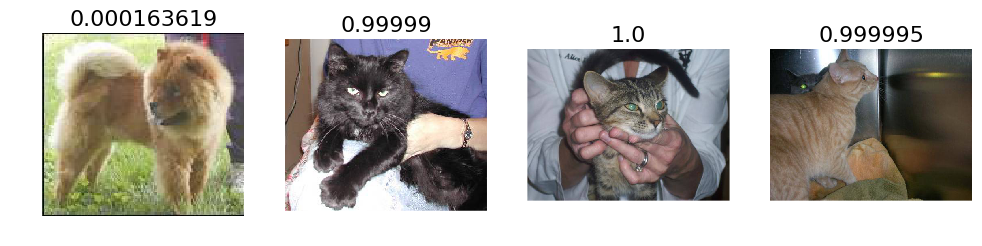

In [133]:
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

### 2. A few incorrect labels at random

Found 37 incorrect labels


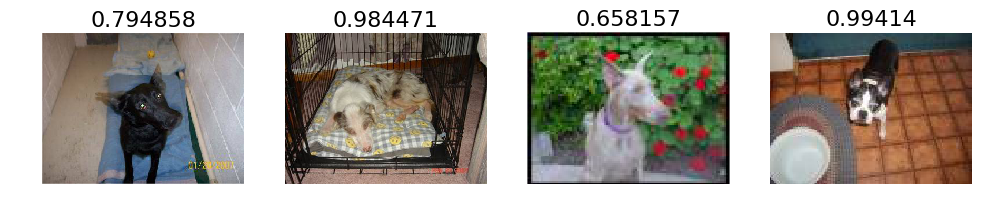

In [134]:
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

### 3a. The images we most confident were cats, and are actually cats

Found 996 confident correct cats labels


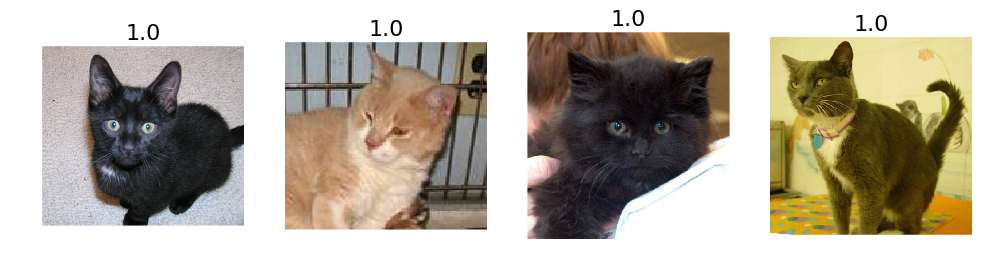

In [135]:
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

### 3b. The images we most confident were dogs, and are actually dogs

Found 967 confident correct dogs labels


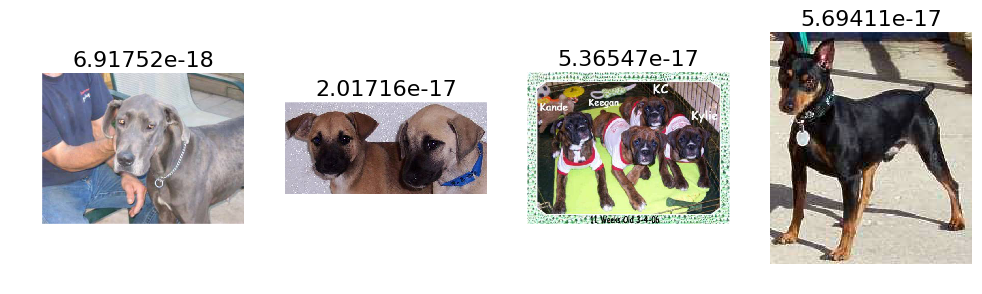

In [136]:
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

### 4a. The images we were most confident were cats, but are actually dogs

Found 33 incorrect cats


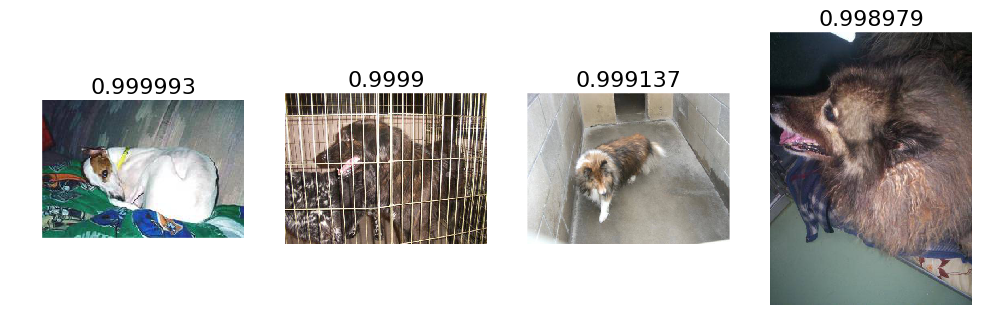

In [137]:
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

### 4b. The images we were most confident were dogs, but are actually cats

Found 4 incorrect dogs


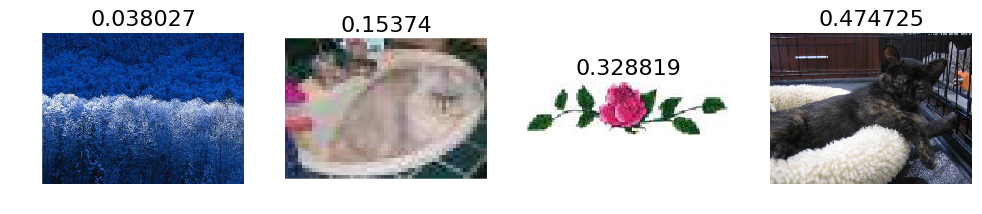

In [139]:
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

### 5. The most uncertain labels (ie those with probability closest to 0.5).

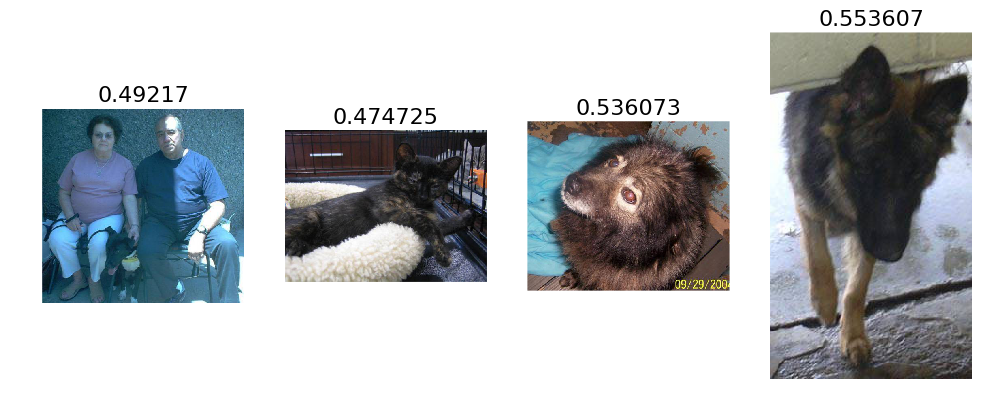

In [140]:
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

### Confusion matrix

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [142]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[996   4]
 [ 33 967]]


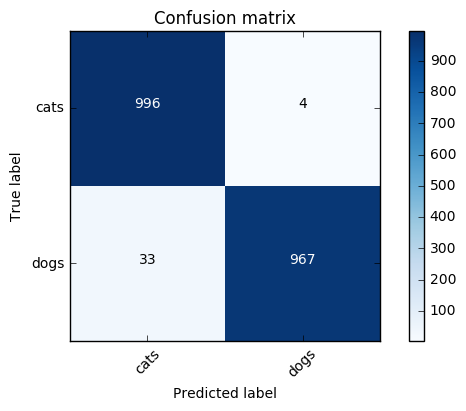

In [143]:
plot_confusion_matrix(cm, val_batches.class_indices)

## 6. Submit predictions to Kaggle

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [7]:
import numpy as np

In [8]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size * 2)

Found 12500 images belonging to 1 classes.


Get filenames of images:

In [9]:
filenames = batches.filenames
filenames[:5]

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg']

Get ids of images:

In [10]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

Get second column (is dog) of predictions array, clipping the values to avoid being penalized by Kaggle:

In [11]:
is_dog = np.clip(preds[:, 1], 0.01, 0.99)
is_dog[:5]

array([ 0.01  ,  0.1295,  0.01  ,  0.01  ,  0.99  ], dtype=float32)

Put both columns (ids and is_dog) next to each other:

In [12]:
subm = np.stack([ids, is_dog], axis = 1)
subm[:5]

array([[  9.2920e+03,   1.0000e-02],
       [  1.2026e+04,   1.2949e-01],
       [  9.6880e+03,   1.0000e-02],
       [  4.3920e+03,   1.0000e-02],
       [  7.7900e+02,   9.9000e-01]])

Save subm as a CSV file:

In [13]:
np.savetxt('data/subm6.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [14]:
from IPython.display import FileLink
FileLink('data/subm6.csv')

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/subm6.csv